<a href="https://colab.research.google.com/github/NasrunSR/Parking-Management-System-Project/blob/main/Parking_Management_System_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parking Management System

The easyocr library is used for Optical Character Recognition (OCR). It can read and extract text from images, PDFs, or other visual inputs in over 80 languages, using deep learning techniques for high accuracy.

1. Install required libraries

In [1]:
pip install easyocr

2. Importing required libraries

In [2]:
import os   #used to provide functions to interact with the operating system.
import cv2    #used in computer vision tasks, image processing, and machine learning.
import numpy as np    #used for numerical computing.
import pandas as pd   #used for data manipulation and analysis
import easyocr
import xml.etree.ElementTree as ET    #provides classes and methods to read XML documents and represent them as a tree structure where each element is a node in the tree

VGG16 - a convolutional neural network that is used for image recognition, image classification and object detection tasks.

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model   #used for defining and building neural network models
from tensorflow.keras.layers import Dense, Flatten    #used to import the Dense and Flatten layers from the TensorFlow Keras API, which are key building blocks for constructing neural network models
from tensorflow.keras.preprocessing.image import ImageDataGenerator   #performing real-time data augmentation on image datasets and loading image data in a memory-efficient way
from tensorflow.keras.models import load_model    #used for loading pre-trained models that have been saved to disk.

3. Data Loading and Preprocessing Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BASE_DIR = '/content/drive/MyDrive/'
WORKING_DIR = '/content'

In [6]:
dataset_path = os.path.join(BASE_DIR, 'Car License Plate Detection Dataset')

In [7]:
# Initialize EasyOCR Reader: to specify the languages you want the OCR engine to recognize.
reader = easyocr.Reader(['en']) # English

# Step 1: Load Dataset and Annotations
images_dir = os.path.join(dataset_path, 'images')
annotations_dir = os.path.join(dataset_path, 'annotations')

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract bounding box information
    for obj in root.findall('object'):
        if obj.find('name').text == 'licence':
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            return (xmin, ymin, xmax, ymax)
    return None

# Step 2: Prepare Data for Training
image_data = []
labels = []

for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        image_file = xml_file.replace('.xml', '.png')
        image_path = os.path.join(images_dir, image_file)
        annotation_path = os.path.join(annotations_dir, xml_file)

        if os.path.exists(image_path):
            bbox = parse_annotation(annotation_path)
            if bbox:
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (224, 224))
                image_data.append(img_resized / 255.0)  # Normalize the image
                labels.append(bbox)

# Convert lists to numpy arrays
X = np.array(image_data)
y = np.array(labels, dtype='float32')

4. Build model using VGG16

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='linear')(x)  # Bounding box coordinates

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

5. Train model

In [10]:
model.fit(X, y, epochs=10, batch_size=32)

# Save the trained model
model.save('car_plate_detection_model.h5')

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1058s 75s/step - accuracy: 0.5177 - loss: 962203.2500
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1048s 71s/step - accuracy: 0.7878 - loss: 27290.7461
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1045s 72s/step - accuracy: 0.7878 - loss: 6783.1201
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 980s 70s/step - accuracy: 0.7872 - loss: 5506.4316
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 995s 71s/step - accuracy: 0.7967 - loss: 5574.1528
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1017s 69s/step - accuracy: 0.7925 - loss: 5748.4194
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 959s 68s/step - accuracy: 0.8244 - loss: 5298.0513
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 986s 69s/step - accuracy: 0.7797 - loss: 5922.9492
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1008s 70s/step - accuracy: 0.8193 - loss: 6983.8032
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 960s 69s/step - accuracy: 0.7773 - loss: 6310.0063


In [11]:
# Detect Car Plates in New Images
def load_image(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = img_array / 255.0
    return img, img_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
Detected License Plate: []


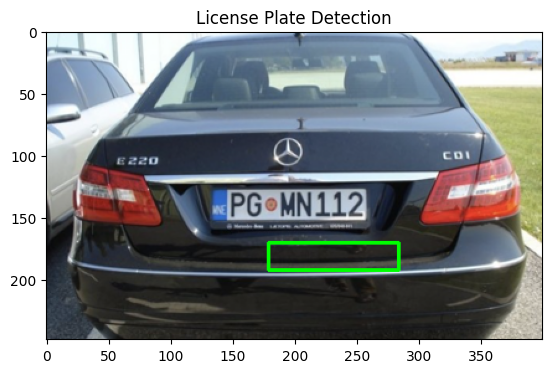

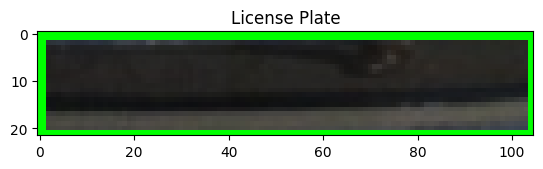

In [12]:
import matplotlib.pyplot as plt
def detect_plate(image_path, model):
    img, img_input = load_image(image_path)

    # Predict bounding box
    pred = model.predict(img_input)[0]
    startX, startY, endX, endY = pred

    # Draw bounding box
    plate_img = img[int(startY):int(endY), int(startX):int(endX)]
    cv2.rectangle(img, (int(startX), int(startY)), (int(endX), int(endY)), (0, 255, 0), 2)

    # Use EasyOCR to extract text from the plate
    plate_text = reader.readtext(plate_img)
    print(f"Detected License Plate: {plate_text}")

    # Display the full image with bounding box
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("License Plate Detection")
    plt.show()

    # Display only the license plate
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("License Plate")
    plt.show()

# Test: Detect license plates from images in the dataset
test_image = os.path.join(images_dir, 'Cars1.png')  # Use an actual test image path
model = load_model('car_plate_detection_model.h5')
detect_plate(test_image, model)
